[![Open In Colab](../images/colab-badge.svg)](https://colab.research.google.com/github/MonashDataFluency/python-web-scraping/blob/master/notebooks/section-4-wrangling-and-analysis.ipynb)

In this section, we will clean, join perform some basic analysis on the data to answer a few questions. Let's import a few libraries we will require.

In [1]:
import re 
import json
import itertools
import pandas as pd
from pathlib import Path
from tabulate import tabulate
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # setting the style to ggplot

Now let's read the `infoboxes.json` file we exported from Section 3 to a dictionary as follows,

In [2]:
# If you dont have the file, you can use the below code to fetch it:
import urllib.request
url = 'https://raw.githubusercontent.com/MonashDataFluency/python-web-scraping/master/data/infoboxes.json'
urllib.request.urlretrieve(url, 'infoboxes.json')

('infoboxes.json', <http.client.HTTPMessage at 0x7fdcac254460>)

In [3]:
with open('infoboxes.json', 'r') as file:
    wiki_data = json.load(file)

and have a quick glance at the first element of the same,

In [5]:
wiki_data[0]

{'founder': '[[Sam Walton]]',
 'location_country': 'U.S.',
 'revenue': '{{increase}} {{US$|514.405 billion|link|=|yes}} (2019)',
 'operating_income': '{{increase}} {{US$|21.957 billion}} (2019)',
 'net_income': '{{decrease}} {{US$|6.67 billion}} (2019)',
 'assets': '{{increase}} {{US$|219.295 billion}} (2019)',
 'equity': '{{decrease}} {{US$|79.634 billion}} (2019)',
 'type': '[[Public company|Public]]',
 'industry': '[[Retail]]',
 'products': '{{hlist|Electronics|Movies and music|Home and furniture|Home improvement|Clothing|Footwear|Jewelry|Toys|Health and beauty|Pet supplies|Sporting goods and fitness|Auto|Photo finishing|Craft supplies|Party supplies|Grocery}}',
 'num_employees': '{{plainlist|\n* 2.2|nbsp|million, Worldwide (2018)|ref| name="xbrlus_1" |\n* 1.5|nbsp|million, U.S. (2017)|ref| name="Walmart"|{{cite web |url = http://corporate.walmart.com/our-story/locations/united-states |title = Walmart Locations Around the World – United States |publisher = |url-status=live |archiveu

 For this excercise, we will primarily focus on the following attributes :
 
 - `products` 	
 - `industries` and 	
 - `assets`  
 
and try to answer a few questions using the data.

### What type of products are sold by the top 20 companies?
---

Looking at a sample for `products`,

In [6]:
for i in range(0,3):
    print(wiki_data[i]['products'])

{{hlist|Electronics|Movies and music|Home and furniture|Home improvement|Clothing|Footwear|Jewelry|Toys|Health and beauty|Pet supplies|Sporting goods and fitness|Auto|Photo finishing|Craft supplies|Party supplies|Grocery}}
{{Unbulleted list
  | [[Crude oil]]
  | [[Oil products]]
  | [[Natural gas]]
  | [[Petrochemical]]s
  | [[Power generation]]}}
[[Investment|Diversified investments]], [[Insurance#Types|Property & casualty insurance]], [[Public utility|Utilities]], [[Restaurants]], [[Food processing]], [[Aerospace]], [[Toys]], [[Mass media|Media]], [[Automotive industry|Automotive]], [[Sports equipment|Sporting goods]], [[Final good|Consumer products]], [[Internet]], [[Real estate]]


We can observe that we need to :

- Extract products from between `{{` and `}}` OR `[[` and `]]`
- Split and seperate by the delimiter `|`
- Only keep alphanumeric characters, `-` and preserve spaces

Let's define a few regular expressions to clean and extract the products from the dictionary.

In [7]:
regex1 = re.compile('[\{\[]+(.*?)[\]\}]')

Regex breakdown :

- `[\{\[]+` : matches one or more `{` or `]`
- `(.*?)` : captures anything between the previous pattern and the next
- `[\]\}]` : matches ending in either `]` or `}` 

 > Note : `\` is used to escape `[]`

Similarly,

In [8]:
regex2 = re.compile('[^a-zA-Z\- ]') # describe the expr

Regex breakdown :

- `[^a-zA-Z\- ]` : matches anything other than (signified by `^`) `a` to `z` OR `A` to `Z` OR `-` OR empty space. 

Patterns like these are useful for replacing or filtering everything else. For practicing regex, try these patterns or your own examples on https://regexr.com/. Now lets clean and extract the data we need as follows,

In [9]:
products = []
data = []

for x in wiki_data:
    y = x['products'] # get products
    z = regex1.findall(y) # extract all products
    z = [d.lower().split('|') for d in z] # get a list 
    m = list(itertools.chain(*z)) # flatten the list of lists using itertools
    m = [regex2.sub('', t) for t in m  if t != 'hlist'] # remove "hlist" (a rogue token)
    data.append({
                'wiki_title' : x['company_name'], 
                'product' : ', '.join(m)
                })
    products.extend(m)
    
print(products)

['electronics', 'movies and music', 'home and furniture', 'home improvement', 'clothing', 'footwear', 'jewelry', 'toys', 'health and beauty', 'pet supplies', 'sporting goods and fitness', 'auto', 'photo finishing', 'craft supplies', 'party supplies', 'grocery', 'crude oil', 'oil products', 'natural gas', 'petrochemical', 'power generation', 'investment', 'diversified investments', 'insurancetypes', 'property  casualty insurance', 'public utility', 'utilities', 'restaurants', 'food processing', 'aerospace', 'toys', 'mass media', 'media', 'automotive industry', 'automotive', 'sports equipment', 'sporting goods', 'final good', 'consumer products', 'internet', 'real estate', 'macintosh', 'ipod', 'iphone', 'ipad', 'apple watch', 'apple tv', 'homepod', 'macos', 'ios', 'ipados', 'watchos', 'tvos', 'ilife', 'iwork', 'final cut pro', 'logic pro', 'garageband', 'shazam application', 'shazam', 'siri', 'uniprise', 'health care', 'service economics', 'services', 'ingenix', 'pharmaceuticals', 'medic

Now let's create a wordcloud function which will visually inform us about which products are more prominent than the others. The size of the word would indicate its frequency.

In [10]:
def create_wordcloud(items, stopwords=[]):
    '''create the wordcloud object
    args
    items :     the items we need to display
    stopwords : a list of stopwords to filter out tokens
    ''' 
    
    text = ' '.join(items)
    wordcloud = WordCloud(width=1600, 
                          height=800, 
                          margin=0, 
                          stopwords=stopwords
                         ).generate(text) # optionally we can set max_words=20 
    
    plt.figure( figsize=(20,10)) # set the final figure size
    plt.imshow(wordcloud, interpolation="bilinear") # pass the image and set interpolation type
    plt.axis("off") # turn all axes off
    plt.tight_layout(pad=0) # no padding
    plt.show() # display plot

Creating wordclouds for `products`,

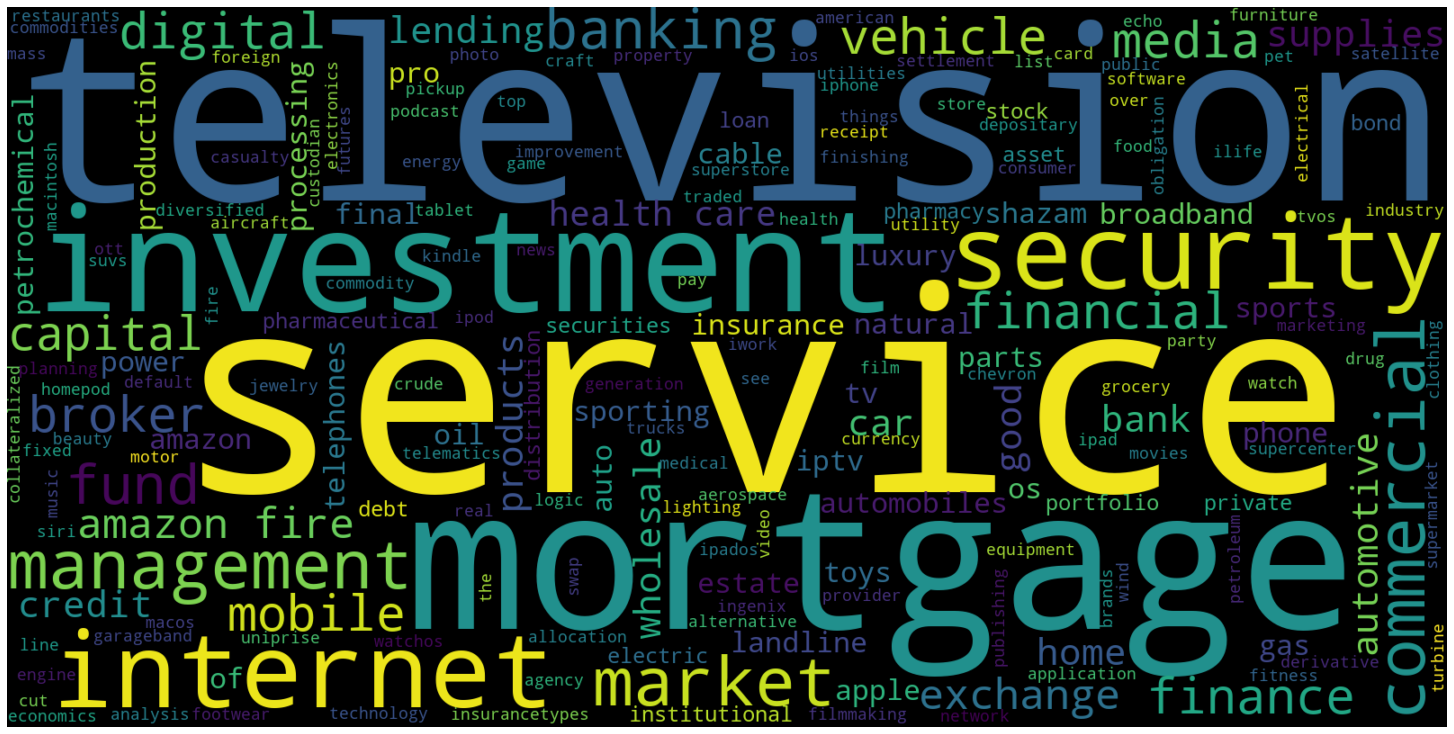

In [11]:
create_wordcloud(products, ['and']) # adding "and" to the stopword list

### What type of industries do the top 20 company belong from?
---

Similarly, looking at a sample for `industry`,

In [12]:
for i in range(0,5):
    print(wiki_data[i]['industry'])

[[Retail]]
[[Energy industry|Energy]]: [[Oil and gas industry|Oil and gas]]
[[Conglomerate (company)|Conglomerate]]
{{Unbulleted list | [[Computer hardware]] | [[Computer software]] | [[Consumer electronics]] | [[Cloud computing]] | [[Digital distribution]] | [[Fabless manufacturing|Fabless silicon design]] | [[Semiconductors]] | [[Financial technology]] | [[Artificial intelligence]]}}
[[Managed health care]]


We can observe that we need to :
- Extract products from between `[[` and `]]`
- Split and seperate by the delimiter `|`
- Only keep alphanumeric characters, `-` and preserve spaces

We define a new regular expression as follows,

In [13]:
regex = re.compile('[\[]+(.*?)[\]]')

Regex breakdown :

- `[\[]+` : matches one or more `[` 
- `(.*?)` : captures anything between the previous pattern and the next
- `[\]]` : matches ending in `]` 


Using the same to clean and extract the industries,

In [14]:
industries = []
for i, x in enumerate(wiki_data):
    y = x['industry'] # get industries
    z = regex.findall(y) # extract industries
    z = [d.lower().split('|') for d in z] # get a list
    m = list(itertools.chain(*z)) # flatten list of lists
    data[i]['industry'] = ', '.join(m)
    industries.extend(m)

print(industries)

['retail', 'energy industry', 'energy', 'oil and gas industry', 'oil and gas', 'conglomerate (company)', 'conglomerate', 'computer hardware', 'computer software', 'consumer electronics', 'cloud computing', 'digital distribution', 'fabless manufacturing', 'fabless silicon design', 'semiconductors', 'financial technology', 'artificial intelligence', 'managed health care', 'healthcare', 'retail', 'health care', 'cloud computing', 'e-commerce', 'artificial intelligence', 'consumer electronics', 'digital distribution', 'grocery stores', 'telecommunications industry', 'telecommunications', 'technology company', 'technology', 'mass media', 'entertainment', 'automotive industry', 'automotive', 'automotive industry', 'automotive', 'pharmaceutical', 'oil and gas industry', 'oil and gas', 'pharmaceuticals', 'retail', 'telecommunications industry', 'telecommunications', 'mass media', 'retail', 'conglomerate (company)', 'conglomerate', 'pharmaceutical', 'retail', 'bank', 'financial services']


Just as before let's create a wordcloud for `industry`,

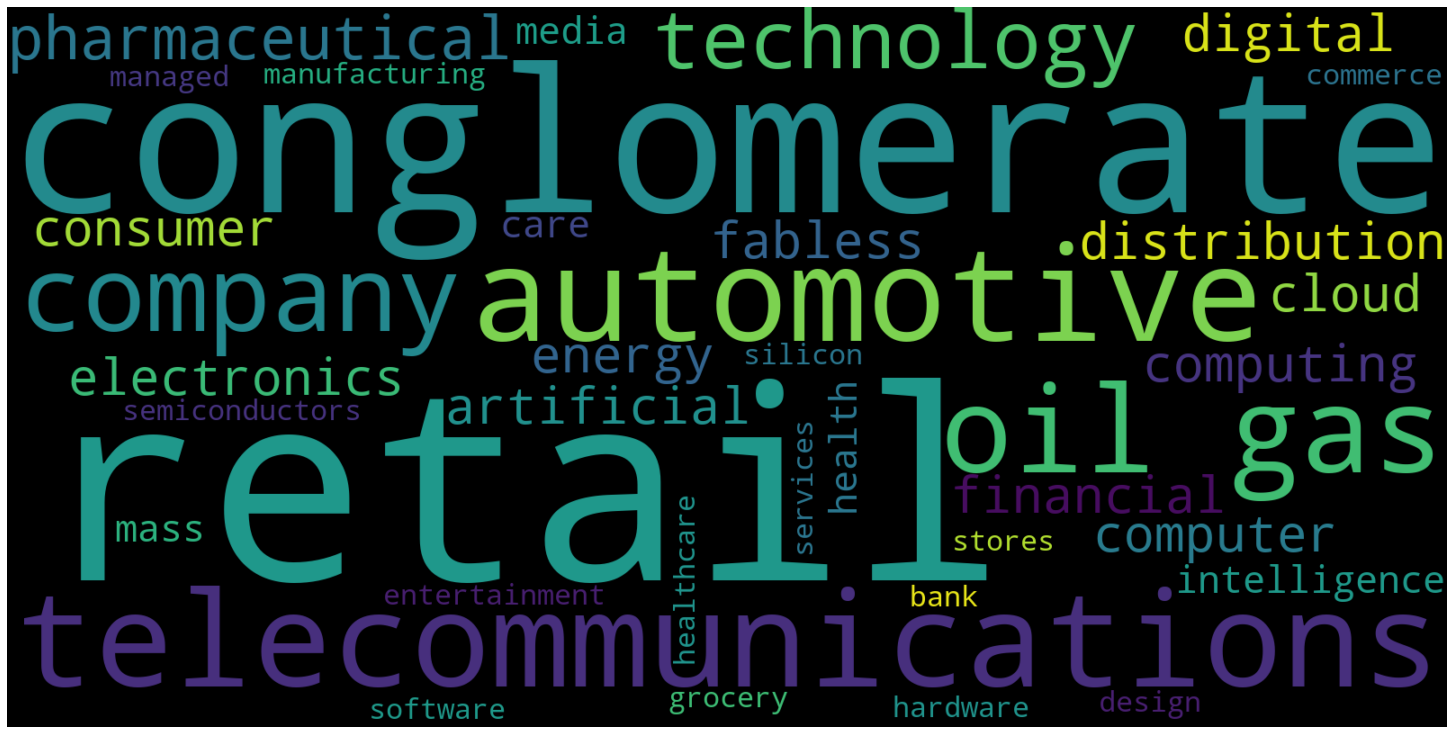

In [15]:
create_wordcloud(industries, ['industry', 'and']) # adding "industry" and "and" to the stopword list 

### What the assets of the top 20 companies look like?
---

Taking a look at a sample of `assets` below,

In [16]:
for i in range(0,len(wiki_data)):
    print(wiki_data[i]['assets'])

{{increase}} {{US$|219.295 billion}} (2019)
{{Nowrap|Decrease| |US$|346.2 billion|ref| name="201310K"}} {{Decrease}} {{US$|346.2 billion}}
{{increase}} US$707.8 billion (2018)
{{Decrease}} {{US$|338.516&nbsp;billion}}
{{increase}} $173.889 billion (2019)
{{nowrap|increase| |US$|60.381 billion| |small|(2018)|ref| name=FY}} {{increase}} {{US$|60.381 billion}} {{small|(2018)}}
{{increase}} {{US$|196.456 billion}}
{{decrease}} {{US$|162.648 billion}}
{{increase}} {{US$|link|=|yes}} 531 billion     (2018)
{{increase}} US$227.339 billion {{small|(2018)}}
{{decrease}} {{US$|256.54 billion}} {{small|(2018)}}
{{increase}} {{US$|37.66 billion}} (2018)
{{decrease}} {{US$|253.9 billion}} {{small|(2018)}}
{{increase}} US$39.95 billion {{small|(2018)}}
{{increase}} US$45.40 billion
{{increase}} {{US$|264.82 billion}}
{{increase}} {{US$|38.11 billion}} (2019)
{{nowrap|Decrease| US$ 309.129 billion |small|(2018)}} {{Decrease}} US$ 309.129 billion {{small|(2018)}}
{{decrease}} {{US$|67.59 billion}}
{{i

We would need to :  

- Extract both numbers and the unit i.e. `billion` or `trillion`  
- Keep only the monetary values (discard year)

We can also observe that the asset value always appears first and then the year follows.

Defining a simple regular expression for the same,

In [17]:
regex1 = re.compile('([\d\.]+)')

Regex breakdown :

- `([\d\.]+)` : matches and captures one or more numbers or `.` (for decimal).

In [18]:
regex2 = re.compile('(billion|trillion)')

Regex breakdown :

- `(billion|trillion)` : matches and captures either `billion` or `trillion`

In [19]:
assets = []
for i, x in enumerate(wiki_data):
    y = x['assets'] # get assets
    z = regex1.findall(y)[0] # extract assets
    unit = regex2.findall(y)[0] # extract the unit
    asset = float(z) # convert to the numeric
    data[i]['assets'] = str(asset) + ' ' + unit
    assets.append({'company' : x['company_name'], 'value' : asset, 'unit' : unit})

assets

[{'company': 'Walmart', 'value': 219.295, 'unit': 'billion'},
 {'company': 'ExxonMobil', 'value': 346.2, 'unit': 'billion'},
 {'company': 'Berkshire Hathaway', 'value': 707.8, 'unit': 'billion'},
 {'company': 'Apple Inc.', 'value': 338.516, 'unit': 'billion'},
 {'company': 'UnitedHealth Group', 'value': 173.889, 'unit': 'billion'},
 {'company': 'McKesson Corporation', 'value': 60.381, 'unit': 'billion'},
 {'company': 'CVS Health', 'value': 196.456, 'unit': 'billion'},
 {'company': 'Amazon (company)', 'value': 162.648, 'unit': 'billion'},
 {'company': 'AT&T', 'value': 531.0, 'unit': 'billion'},
 {'company': 'General Motors', 'value': 227.339, 'unit': 'billion'},
 {'company': 'Ford Motor Company', 'value': 256.54, 'unit': 'billion'},
 {'company': 'AmerisourceBergen', 'value': 37.66, 'unit': 'billion'},
 {'company': 'Chevron Corporation', 'value': 253.9, 'unit': 'billion'},
 {'company': 'Cardinal Health', 'value': 39.95, 'unit': 'billion'},
 {'company': 'Costco', 'value': 45.4, 'unit': 'b

Since we have both `billion` as well as `trillion`, let's normalize all the values,

In [20]:
for i, asset in enumerate(assets):
    if asset['unit'] == 'trillion': # if unit is in trillion
        assets[i]['value'] = asset['value']*1000 # convert to trillion to billion
        assets[i]['unit'] = 'billion'

And create a new dataframe from the same,

In [6]:
df_assets = pd.DataFrame(assets)
df_assets

|    | company                  |    value | unit    |
|---:|:-------------------------|---------:|:--------|
|  0 | Walmart                  |  219.295 | billion |
|  1 | ExxonMobil               |  346.2   | billion |
|  2 | Berkshire Hathaway       |  707.8   | billion |
|  3 | Apple Inc.               |  338.516 | billion |
|  4 | UnitedHealth Group       |  173.889 | billion |
|  5 | McKesson Corporation     |   60.381 | billion |
|  6 | CVS Health               |  196.456 | billion |
|  7 | Amazon (company)         |  162.648 | billion |
|  8 | AT&T                     |  531     | billion |
|  9 | General Motors           |  227.339 | billion |
| 10 | Ford Motor Company       |  256.54  | billion |
| 11 | AmerisourceBergen        |   37.66  | billion |
| 12 | Chevron Corporation      |  253.9   | billion |
| 13 | Cardinal Health          |   39.95  | billion |
| 14 | Costco                   |   45.4   | billion |
| 15 | Verizon Communications   |  264.82  | billion |
| 16 | Kroger                   |   38.11  | billion |
| 17 | General Electric         |  309.129 | billion |
| 18 | Walgreens Boots Alliance |   67.59  | billion |
| 19 | JPMorgan Chase           | 2687     | billion |


Now finally let's create a bar plot showcasing the assets from all the companies,

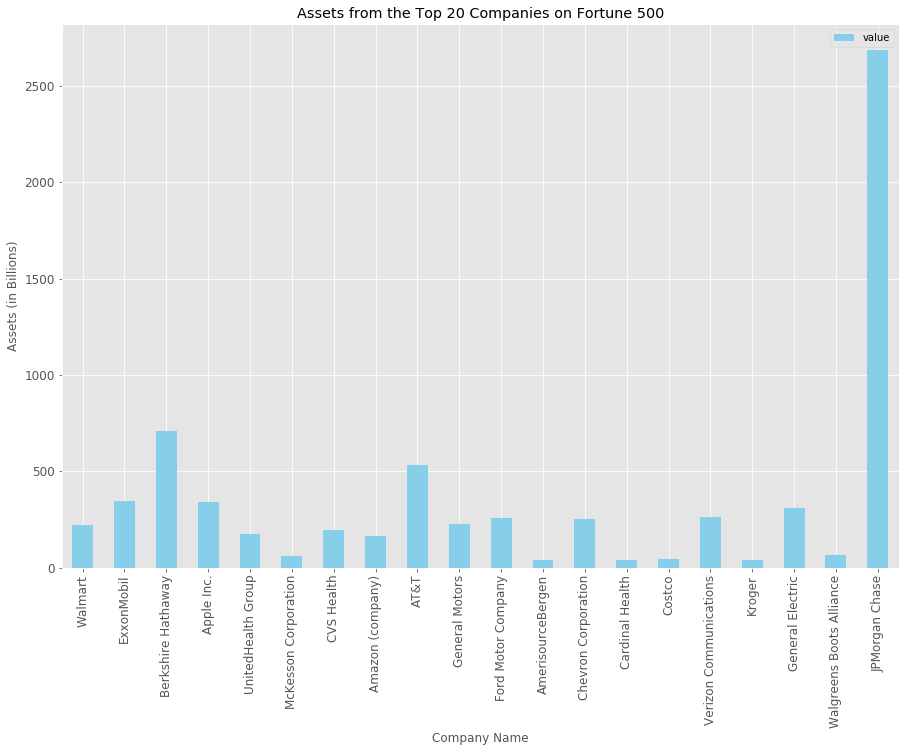

In [22]:
ax = df_assets.plot(kind='bar', 
               title ="Assets from the Top 20 Companies on Fortune 500",
               color='skyblue',
               figsize=(15, 10), 
               legend=True, 
               fontsize=12
              )

ax.set_xticklabels(df_assets.company)
ax.set_xlabel("Company Name", fontsize=12)
ax.set_ylabel("Assets (in Billions)", fontsize=12)
plt.show()

Now let's create a new dataframe containing data related to `products`, `industry` and `assets` as follows,

In [2]:
df_wiki = pd.DataFrame(data)
df_wiki.head()

|    | wiki_title         | product                                                                                                                                                                                                                                                                                                 | industry                                                                                                                                                                                                        | assets          |
|---:|:-------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------|
|  0 | Walmart            | electronics, movies and music, home and furniture, home improvement, clothing, footwear, jewelry, toys, health and beauty, pet supplies, sporting goods and fitness, auto, photo finishing, craft supplies, party supplies, grocery                                                                     | retail                                                                                                                                                                                                          | 219.295 billion |
|  1 | ExxonMobil         | crude oil, oil products, natural gas, petrochemical, power generation                                                                                                                                                                                                                                   | energy industry, energy, oil and gas industry, oil and gas                                                                                                                                                      | 346.2 billion   |
|  2 | Berkshire Hathaway | investment, diversified investments, insurancetypes, property  casualty insurance, public utility, utilities, restaurants, food processing, aerospace, toys, mass media, media, automotive industry, automotive, sports equipment, sporting goods, final good, consumer products, internet, real estate | conglomerate (company), conglomerate                                                                                                                                                                            | 707.8 billion   |
|  3 | Apple Inc.         | macintosh, ipod, iphone, ipad, apple watch, apple tv, homepod, macos, ios, ipados, watchos, tvos, ilife, iwork, final cut pro, logic pro, garageband, shazam application, shazam, siri                                                                                                                  | computer hardware, computer software, consumer electronics, cloud computing, digital distribution, fabless manufacturing, fabless silicon design, semiconductors, financial technology, artificial intelligence | 338.516 billion |
|  4 | UnitedHealth Group | uniprise, health care, service economics, services, ingenix                                                                                                                                                                                                                                             | managed health care                                                                                                                                                                                             | 173.889 billion |

And finally let's combine the datasets from Section 2 and 3 as follows,

In [24]:
# If you dont have the file, you can use the below code to fetch it:
import urllib.request
url = 'https://raw.githubusercontent.com/MonashDataFluency/python-web-scraping/master/data/fortune_500_companies.csv'
urllib.request.urlretrieve(url, 'fortune_500_companies.csv')

('fortune_500_companies.csv', <http.client.HTTPMessage at 0x2cf4823f978>)

In [1]:
df = pd.read_csv('fortune_500_companies.csv', nrows=20) # reading only the first 20 rows
df = pd.concat([df, df_wiki], axis=1) # concatenating both the datasets
df

|    |   rank | company_name             | company_website                       | wiki_title               | product                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | industry                                                                                                                                                                                                        | assets          |
|---:|-------:|:-------------------------|:--------------------------------------|:-------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------|
|  0 |      1 | Walmart                  | http://www.stock.walmart.com          | Walmart                  | electronics, movies and music, home and furniture, home improvement, clothing, footwear, jewelry, toys, health and beauty, pet supplies, sporting goods and fitness, auto, photo finishing, craft supplies, party supplies, grocery                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | retail                                                                                                                                                                                                          | 219.295 billion |
|  1 |      2 | Exxon Mobil              | http://www.exxonmobil.com             | ExxonMobil               | crude oil, oil products, natural gas, petrochemical, power generation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | energy industry, energy, oil and gas industry, oil and gas                                                                                                                                                      | 346.2 billion   |
|  2 |      3 | Berkshire Hathaway       | http://www.berkshirehathaway.com      | Berkshire Hathaway       | investment, diversified investments, insurancetypes, property  casualty insurance, public utility, utilities, restaurants, food processing, aerospace, toys, mass media, media, automotive industry, automotive, sports equipment, sporting goods, final good, consumer products, internet, real estate                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | conglomerate (company), conglomerate                                                                                                                                                                            | 707.8 billion   |
|  3 |      4 | Apple                    | http://www.apple.com                  | Apple Inc.               | macintosh, ipod, iphone, ipad, apple watch, apple tv, homepod, macos, ios, ipados, watchos, tvos, ilife, iwork, final cut pro, logic pro, garageband, shazam application, shazam, siri                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | computer hardware, computer software, consumer electronics, cloud computing, digital distribution, fabless manufacturing, fabless silicon design, semiconductors, financial technology, artificial intelligence | 338.516 billion |
|  4 |      5 | UnitedHealth Group       | http://www.unitedhealthgroup.com      | UnitedHealth Group       | uniprise, health care, service economics, services, ingenix                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | managed health care                                                                                                                                                                                             | 173.889 billion |
|  5 |      6 | McKesson                 | http://www.mckesson.com               | McKesson Corporation     | pharmaceuticals, medical technology, health care services                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | healthcare                                                                                                                                                                                                      | 60.381 billion  |
|  6 |      7 | CVS Health               | http://www.cvshealth.com              | CVS Health               |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | retail, health care                                                                                                                                                                                             | 196.456 billion |
|  7 |      8 | Amazon.com               | http://www.amazon.com                 | Amazon (company)         | amazon echo, amazon fire tablet, amazon fire, amazon fire tv, fire os, amazon fire os, amazon kindle                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | cloud computing, e-commerce, artificial intelligence, consumer electronics, digital distribution, grocery stores                                                                                                | 162.648 billion |
|  8 |      9 | AT&T                     | http://www.att.com                    | AT&T                     | satellite television, landline, fixed-line telephones, mobile phone, mobile telephones, internet service provider, internet services, broadband, digital television, home security, iptv, over-the-top media services, ott services, network security, filmmaking, film production, television production, cable television, pay television, publishing, podcast, sports management, news agency, video game                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | telecommunications industry, telecommunications, technology company, technology, mass media, entertainment                                                                                                      | 531.0 billion   |
|  9 |     10 | General Motors           | http://www.gm.com                     | General Motors           | car, automobiles, commercial vehicle                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | automotive industry, automotive                                                                                                                                                                                 | 227.339 billion |
| 10 |     11 | Ford Motor               | http://www.corporate.ford.com         | Ford Motor Company       | car, automobiles, luxury car, luxury vehicles, commercial vehicle, commercial vehicles, list of auto parts, automotive parts, pickup trucks, suvs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | automotive industry, automotive                                                                                                                                                                                 | 256.54 billion  |
| 11 |     12 | AmerisourceBergen        | http://www.amerisourcebergen.com      | AmerisourceBergen        | pharmaceutical, pharmacy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | pharmaceutical                                                                                                                                                                                                  | 37.66 billion   |
| 12 |     13 | Chevron                  | http://www.chevron.com                | Chevron Corporation      | petroleum, natural gas, petrochemical, marketing brands, see chevron products                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | oil and gas industry, oil and gas                                                                                                                                                                               | 253.9 billion   |
| 13 |     14 | Cardinal Health          | http://www.cardinalhealth.com         | Cardinal Health          |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | pharmaceuticals                                                                                                                                                                                                 | 39.95 billion   |
| 14 |     15 | Costco                   | http://www.costco.com                 | Costco                   |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | retail                                                                                                                                                                                                          | 45.4 billion    |
| 15 |     16 | Verizon                  | http://www.verizon.com                | Verizon Communications   | cable television, landline, mobile phone, broadband, digital television, iptv, digital media, internet of things, internet, telematics                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | telecommunications industry, telecommunications, mass media                                                                                                                                                     | 264.82 billion  |
| 16 |     17 | Kroger                   | http://www.thekrogerco.com            | Kroger                   | supercenter, superstore, supermarket                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | retail                                                                                                                                                                                                          | 38.11 billion   |
| 17 |     18 | General Electric         | http://www.ge.com                     | General Electric         | aircraft engine, electric power distribution, electrical distribution, electric motor, energy, finance, health care, lighting, software, wind turbine                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | conglomerate (company), conglomerate                                                                                                                                                                            | 309.129 billion |
| 18 |     19 | Walgreens Boots Alliance | http://www.walgreensbootsalliance.com | Walgreens Boots Alliance | drug store, pharmacy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | pharmaceutical, retail                                                                                                                                                                                          | 67.59 billion   |
| 19 |     20 | JPMorgan Chase           | http://www.jpmorganchase.com          | JPMorgan Chase           | alternative financial service, american depositary receipt, asset allocation, asset management, bond finance, bond, broker, capital market, collateralized debt obligation, commercial banking, commodity market, commodities, commercial bank, credit card, credit default swap, credit derivative, currency exchange, custodian bank, debt settlement, digital banking, estate planning, exchange-traded fund, financial analysis, financial market, foreign exchange market, futures exchange, hedge fund, index fund, information processing, institutional investor, institutional investing, insurance, investment bank, financial capital, investment capital, investment management, portfolio finance, portfolios, loan servicing, merchant services, mobile banking, money market, mortgage brokers, mortgage broker, mortgage loan, mortgage-backed security, mortgagebacked securities, mutual fund, pension fund, prime brokerage, private banking, private equity, remittance, retail banking, broker, risk management, securities lending, security finance, security, stock trader, stock trading, subprime lending, treasury services, trustee, underwriting, venture capital, wealth management, wholesale funding, wholesale mortgage lenders, wholesale mortgage lending, wire transfer | bank, financial services                                                                                                                                                                                        | 2.687 trillion  |


And export them to a csv file,

In [26]:
df.to_csv('top_20_companies.csv', index=False)

#### Challenge
---

Create a bar chart of `equity` of all the top 20 Fortune 500 companies and find out which has the highest value.